# I. Linear least squares approximation

Consider a function $y = f(x)$ which is defined by a set of values $y_0, y_1, \cdots, y_n$ at points $x_0, x_1, \cdots, x_n$.

In [17]:
import numpy as np
x = np.array([-1, -0.7, -0.43, -0.14, -0.14, 0.43, 0.71, 1, 1.29, 1.57, 1.86, 2.14, 2.43, 2.71, 3])
y = np.array([-2.25, -0.77, 0.21, 0.44, 0.64, 0.03, -0.22, -0.84, -1.2, -1.03, -0.37, 0.61, 2.67, 5.04, 8.90])

### I.I. Find a best fit polynomial

$$
P_m(x) = a_0 + a_1 x + \cdots + a_m x^m
$$

using the linear least squares approach. To this end

1. implement a function which constructs the design matrix using $1, x, \cdots, x^m$ as the basis functions.

2. construct explicitly the normal system of equations of the linear least squares problem at fixed $m$.

3. Solve the normal equations to find the coefficients of $P_m(x)$ for $m = 0, 1, 2, \dots$. For the linear algebra problem, you can either use library functions (`numpy.linalg.solve`) or your LU factorization code from week 1.

(20% of the total grade)

Design matrix is
$$
A_{jk} = \phi_{k}(x_j) = x_j^k
$$

In [18]:
def get_design_a(x, m):
    a = np.zeros((x.shape[0], m+1))
    a[:,0] = 1
    
    vec = x.copy()
    a[:, 1] = vec
    
    for j in range(2, m+1):
        vec = vec * x
        a[:, j] = vec
    
    return a

To minimize system we have to solution next system:
$$
A^{T}A \,\mathbf{a} = A^{T} \mathbf{y}
$$

In [19]:
def get_system(A, y):
    return A.T @ A , A.T @ y

In [20]:
def find_best_pol(x, y, m):
    A = get_design_a(x, m)
    sys = get_system(A, y)
    a = np.linalg.solve(sys[0],sys[1])
    return a

### I.II 

To find the optimal value of m, use the following criterion: take $m=0, 1, 2, \dots$, for each value of $m$ compute 

$$
\sigma_m^2 = \frac{1}{n - m} \sum_{k=0}^n \left( P_m(x_k) - y_k \right)^2
$$

And take the value of $m$, at which $\sigma_m$ stabilizes or starts increasing.

(20% of the total grade)

In [21]:
def get_sigma(x, y, N=5):
    sigma = np.zeros(N+1)
    n = y.shape[0]
    sigma[0] = (np.mean(y) - y) @ (np.mean(y) - y) / n
    for m in range(1, N+1):
        A = get_design_a(x, m)
        a = find_best_pol(x, y, m)
        sigma[m] = 1/(n-m) * (A @ a - y) @ (A @ a - y)
    return sigma

<IPython.core.display.Javascript object>


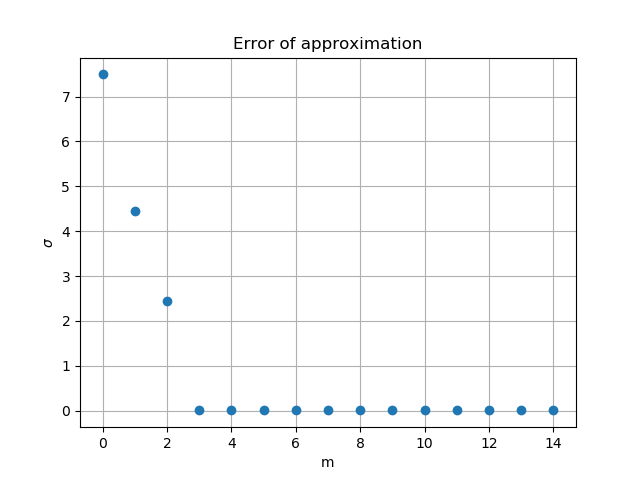

In [22]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()
plt.title(r'Error of approximation')
plt.xlabel('m')
plt.ylabel(r'$\sigma$')
plt.grid()
plt.plot(get_sigma(x, y, N=x.shape[0]-1), 'o')
#plt.yscale('log')
plt.show()

Plot your polynomials $P_m(x)$ on one plot, together with the datapoints. Visually compare best-fit polynomials of different degrees. Is the visual comparison consistent with the optimal value of $m$?

<IPython.core.display.Javascript object>


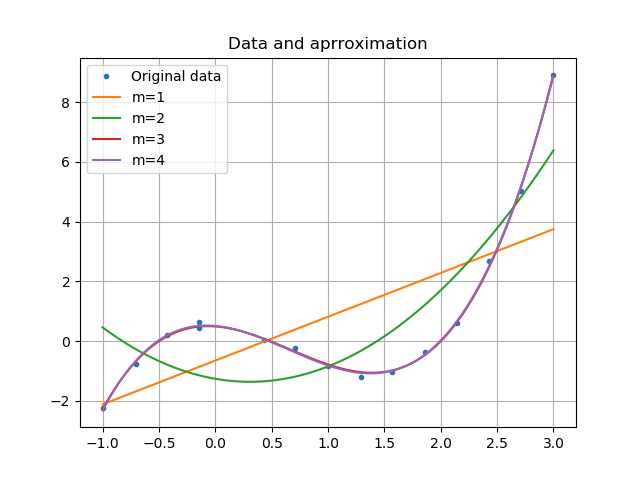

In [23]:
%matplotlib notebook
plt.figure()
plt.title(r'Data and aprroximation')
x_view = np.linspace(x.min(), x.max(), 500)
N = 4
plt.plot(x, y, '.', label='Original data')
for m in range(1, N+1):
    A = get_design_a(x, m)
    a = find_best_pol(x, y, m)
    y_view = get_design_a(x_view, m) @ a
    plt.plot(x_view, y_view, label=f'm={m}')
plt.grid()
plt.legend()
plt.show()

### I.III. Linear least-squares using the QR factorization.

For the optimal value of $m$ from the previous part, solve the LLS problem using the QR factorization, withou ever forming the normal equations explicitly. For linear algebra, you can use standard library functions (look up `numpy.linalg.solve`, `numpy.linalg.qr` etc) or your code from previous weeks.

Compare the results with the results of solving the normal system of equations.

(20% of the grade)

In [24]:
from scipy.linalg import solve_triangular
def find_byqr(x, y, m):
    A = get_design_a(x, m)
    q,r = np.linalg.qr(A)
    f = (q.T @ y)
    a = solve_triangular(r, f)
    return a

<IPython.core.display.Javascript object>


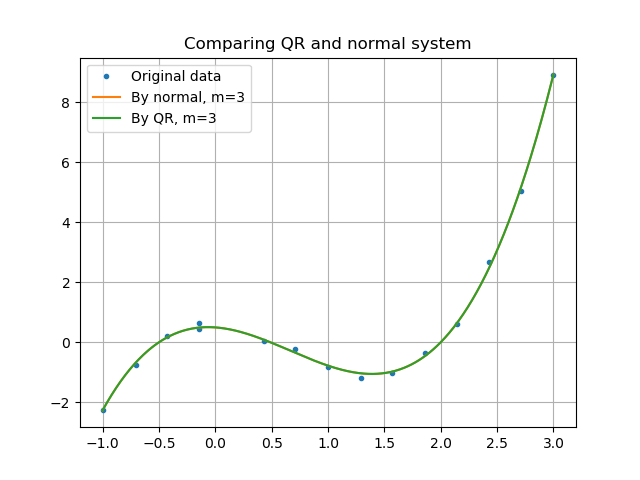

In [25]:
%matplotlib notebook
plt.figure()
plt.title(r'Comparing QR and normal system')
x_view = np.linspace(x.min(), x.max(), 500)
m = 3
plt.plot(x, y, '.', label='Original data')

A = get_design_a(x, m)

a = find_best_pol(x, y, m)
y_view = get_design_a(x_view, m) @ a
plt.plot(x_view, y_view, label=f'By normal, m={m}')

a = find_byqr(x, y, m)
y_view = get_design_a(x_view, m) @ a
plt.plot(x_view, y_view, label=f'By QR, m={m}')

plt.grid()
plt.legend()
plt.show()

In [26]:
print(find_best_pol(x, y, m)-find_byqr(x, y, m))

[ 1.85407245e-14  1.70974346e-14 -4.44089210e-14  1.33226763e-14]


# II. Lagrange interpolation

### II.1 

Consider the function, $f(x) = x^2 \cos{x}$. On the interval $x\in [\pi/2, \pi]$, interpolate the function using the Lagrange interpolating polynomial of degree $m$ with $m=1, 2, 3, 4, 5$. Use the uniform mesh. Plot the resulting interpolants together with $f(x)$.

(20% of the total grade)

In [27]:
def lagrange(x_new, roots, value):
    n = roots.shape[0]
    p = 0
    for i in range(n):
        li=1
        ri = roots[i]
        for root in roots:
            li = li * (x_new - root) / (ri - root) if root != ri else li
        p += value[i] * li
    return p
lg =  np.vectorize(lagrange, signature='(n),(m),(m)->(n)')

<IPython.core.display.Javascript object>


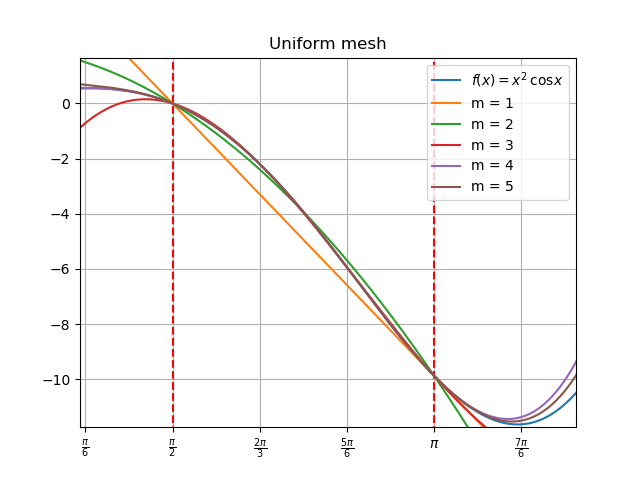

In [89]:
%matplotlib notebook
plt.plot()
plt.grid()
plt.title('Uniform mesh')
N = 3
x_view = np.linspace(np.pi/4, np.pi*1.5, 700)
y = x_view*x_view*np.cos(x_view)
plt.plot(x_view , y, label=r'$f(x) = x^2\, \cos x$')

for m in range(1, 6):
    roots = np.linspace(np.pi/2, np.pi, m+1)
    value = roots*roots*np.cos(roots)
    #plt.plot(roots, value,'.')


    y_view = lg(x_view, roots, value)

    plt.plot(x_view , y_view, label=f'm = {m}')


plt.xticks(np.linspace(np.pi/3,np.pi*7/6,6), 
          (r'$\frac{\pi}{6}$' , r'$\frac{\pi}{2}$',r'$\frac{2\pi}{3}$',r'$\frac{5\pi}{6}$',r'$\pi$',r'$\frac{7\pi}{6}$'))
plt.vlines(np.pi, -12, 1.5, colors='r', linestyles='--')
plt.vlines(np.pi/2, -12, 1.5, colors='r', linestyles='--')
plt.legend()

### II.2. 

Repeat the previous task using the Chebyshev nodes. Compare the quality of interpolation on a uniform mesh and Chebyshev nodes for $m=3$.

(20% of the total grade)

In [42]:
def get_roots(a, b, n):
    df = np.pi / n
    phase = [np.pi / 2 / n]
    for _ in range(n-1):
        phase.append(phase[-1]+df)
    phase = np.array(phase)
    roots = (a+b)/2 + (b-a)/2*np.cos(phase)
    return roots

<IPython.core.display.Javascript object>


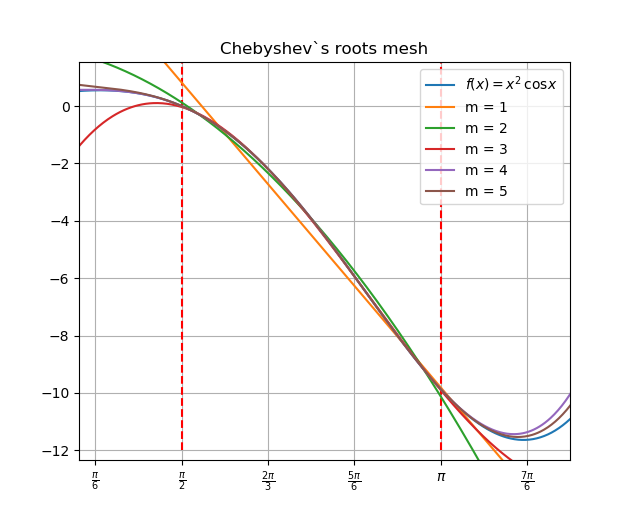

In [88]:
%matplotlib notebook
plt.plot()
plt.grid()
plt.title('Chebyshev`s roots mesh')
N = 3
x_view = np.linspace(np.pi/4, np.pi*1.5, 700)
y = x_view*x_view*np.cos(x_view)
plt.plot(x_view , y, label=r'$f(x) = x^2\, \cos x$')

for m in range(1, 6):
    roots = get_roots(np.pi/2, np.pi, m+1)
    value = roots*roots*np.cos(roots)
    #plt.plot(roots, value,'.')


    y_view = lg(x_view, roots, value)

    plt.plot(x_view , y_view, label=f'm = {m}')

plt.xticks(np.linspace(np.pi/3,np.pi*7/6,6), 
          (r'$\frac{\pi}{6}$' , r'$\frac{\pi}{2}$',r'$\frac{2\pi}{3}$',r'$\frac{5\pi}{6}$',r'$\pi$',r'$\frac{7\pi}{6}$'))
plt.vlines(np.pi, -12, 1.5, colors='r', linestyles='--')
plt.vlines(np.pi/2, -12, 1.5, colors='r', linestyles='--')

plt.legend()

<IPython.core.display.Javascript object>


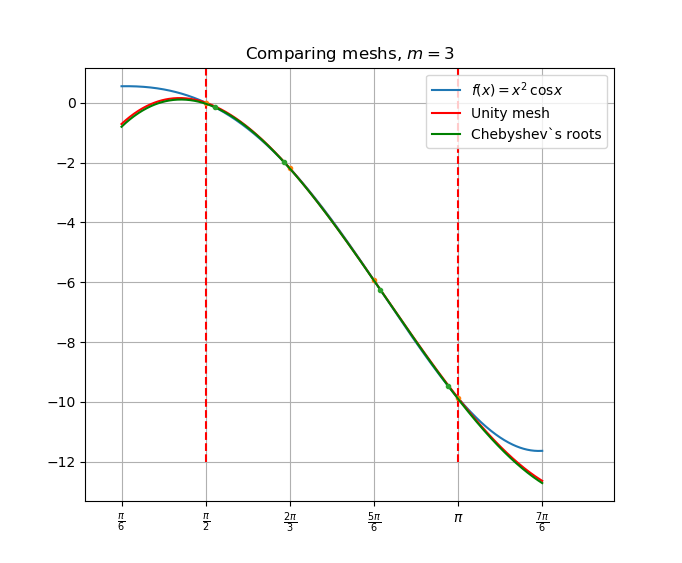

In [70]:
%matplotlib notebook
plt.plot()
plt.grid()
plt.title(r'Comparing meshs, $m=3$')
N = 3
x_view = np.linspace(np.pi/3, np.pi*7/6, 700)
y = x_view*x_view*np.cos(x_view)
plt.plot(x_view , y, label=r'$f(x) = x^2\, \cos x$')

for m in range(3, 4):
    roots = np.linspace(np.pi/2, np.pi, m+1)
    value = roots*roots*np.cos(roots)
    
    y_view = lg(x_view, roots, value)

    plt.plot(x_view , y_view,'r-', label='Unity mesh')
    plt.plot(roots, value,'.')

for m in range(3, 4):
    roots = get_roots(np.pi/2, np.pi, m+1)
    value = roots*roots*np.cos(roots)
    
    y_view = lg(x_view, roots, value)

    plt.plot(x_view , y_view,'g-',label='Chebyshev`s roots')
    plt.plot(roots, value,'.')

plt.xticks(np.linspace(np.pi/3,np.pi*7/6,6), 
          (r'$\frac{\pi}{6}$' , r'$\frac{\pi}{2}$',r'$\frac{2\pi}{3}$',r'$\frac{5\pi}{6}$',r'$\pi$',r'$\frac{7\pi}{6}$'))
plt.vlines(np.pi, -12, 1.5, colors='r', linestyles='--')
plt.vlines(np.pi/2, -12, 1.5, colors='r', linestyles='--')

plt.legend()



<IPython.core.display.Javascript object>


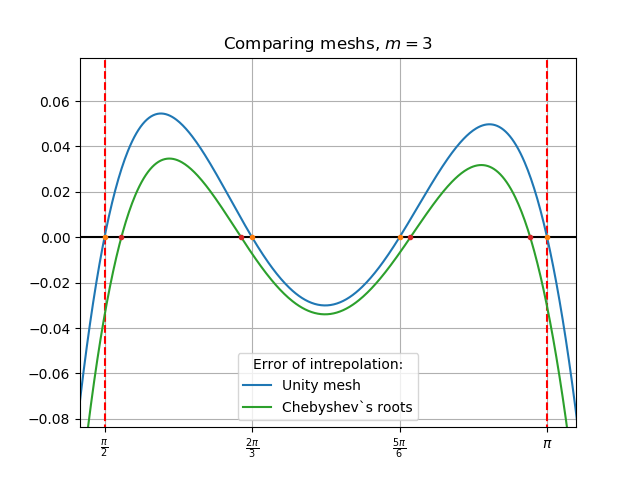

In [65]:
%matplotlib notebook
plt.plot()
plt.grid()
plt.title(r'Comparing meshs, $m = 3$')
N = 3
x_view = np.linspace(np.pi/3, np.pi*7/6, 700)
y = x_view*x_view*np.cos(x_view)
#plt.plot(x_view , y, label=r'$f(x) = x^2\, \cos x$')

for m in range(3, 4):
    roots = np.linspace(np.pi/2, np.pi, m+1)
    value = roots*roots*np.cos(roots)
    
    y_view = lg(x_view, roots, value)

    plt.plot(x_view , y_view-y, label='Unity mesh')
    plt.plot(roots, np.zeros_like(roots),'.')

for m in range(3, 4):
    roots = get_roots(np.pi/2, np.pi, m+1)
    value = roots*roots*np.cos(roots)
    
    y_view = lg(x_view, roots, value)

    plt.plot(x_view , y_view-y, label='Chebyshev`s roots')
    plt.plot(roots, np.zeros_like(roots),'.')

plt.xticks(np.linspace(np.pi/3,np.pi*7/6,6), 
          (r'$\frac{\pi}{6}$' , r'$\frac{\pi}{2}$',r'$\frac{2\pi}{3}$',r'$\frac{5\pi}{6}$',r'$\pi$',r'$\frac{7\pi}{6}$'))
plt.vlines(np.pi, -1, 1.5, colors='r', linestyles='--')
plt.vlines(np.pi/2, -1, 1.5, colors='r', linestyles='--')
plt.hlines(0, np.pi/3,np.pi*7/6, colors='black', linestyles='-')

plt.legend(title = r'Error of intrepolation:')



As we can see, Chebyshev's roots gets less derivation from zerow, but in some changes we need to reduce $L_2$ norm:
$$
\| L_2(g(x))\| = \int g^2 \text{d}x
$$
Let compute this norm in our cases

In [84]:
x_view = np.linspace(np.pi/2, np.pi, 700)
y = x_view*x_view*np.cos(x_view)
dx = x_view[1] - x_view[0]
print('chebyshev`s roots:')
for m in range(1, 6):
    roots = get_roots(np.pi/2, np.pi, m+1)
    value = roots*roots*np.cos(roots)
    y_view = lg(x_view, roots, value)
    err = (y-y_view) @ (y-y_view) * dx 
    print( 'm=',m,'e=' ,'%.2e' % err) 


chebyshev`s roots:
m= 1 e= 2.40e-01
m= 2 e= 2.90e-02
m= 3 e= 8.70e-04
m= 4 e= 9.35e-07
m= 5 e= 1.05e-07


In [86]:
x_view = np.linspace(np.pi/2, np.pi, 700)
y = x_view*x_view*np.cos(x_view)
dx = x_view[1] - x_view[0]
print('unity roots:')
for m in range(1, 6):
    roots = np.linspace(np.pi/2, np.pi, m+1)
    value = roots*roots*np.cos(roots)
    y_view = lg(x_view, roots, value)
    err = (y-y_view) @ (y-y_view) * dx 
    print( 'm=',m,'e=' ,'%.2e' % err) 


unity roots:
m= 1 e= 8.61e-01
m= 2 e= 7.20e-02
m= 3 e= 1.66e-03
m= 4 e= 1.93e-06
m= 5 e= 2.17e-07


As u will see, chevyshev wins here too

In the conclusion I would like to notice that If we definde mesure 'goodness' of intrepolation as

$$
G_f[P_m](\varepsilon) = \mu^*(x : |f(x) - P_m(x)|>\varepsilon), \text{ where } \mu^* \text{- Lebeg's measure}
$$
we can observe fact, that chevyshev wins here too.